In [1]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas

%matplotlib inline

In [2]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
import utils.overlapBins as overlapBins
import utils.compound as compound

%run helpers/impactPlots.ipynb
%run utils/emergence.ipynb



In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
prXr=xarray.open_dataset('results/cmip6PrXr.nc')
detrendTsXr=xarray.open_dataset('results/cmip6DetrendTsXr.nc')


In [5]:
def detrend(xr):
    return xr-xr.rolling(year=30,min_periods=15,center=True).mean('year')

# Find events in the e and c indeces

 1 sigma above/below mean
Using a piControl climatology

In [6]:
ecXr=xarray.open_dataset('results/cmip6EcIndex.nc')

piControlEcXr=ecXr.sel(experiment='piControl', drop=True)


# This should calculate stds for all experiments and all indeces
stdEcXr = piControlEcXr.std(dim='year')
stdEcXr

<xarray.Dataset>
Dimensions:  (model: 37)
Coordinates:
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    eIndex   (model) float64 0.6339 0.8717 0.6902 0.6543 ... 0.7986 0.75 0.7068
    cIndex   (model) float64 0.962 0.8771 0.8874 0.8806 ... 0.841 0.8212 0.8975

Apply the 1 sigma criteria

In [7]:
ecDetrendXr=ecXr-ecXr.rolling(year=30,min_periods=15,center=True).mean('year')

In [8]:
firePosEc, fireNegEc = compound.applyCriteria(ecDetrendXr, stdEcXr)

firePos: 
['cIndex', 'eIndex']
fireNeg: 
[]


In [9]:
# find where either index is saying there is an event
# this is a bit messy, you need to make sure Nan years stay as Nan (years for the piControl is different for all the models)

firePosEc['ecCombined']=(((firePosEc.cIndex+firePosEc.eIndex)>0)*1).where(
        firePosEc.cIndex.isnull()==False)
fireNegEc['ecCombined']=(((fireNegEc.cIndex+fireNegEc.eIndex)>0)*1).where(
    fireNegEc.cIndex.isnull()==False)


# Find events in the trad indeces

In [10]:
tradIndecesXr = xarray.concat([
    xarray.open_dataset('results/cmip6'+experiment+'TradIndecesTos.nc') for experiment in ['piControl','ssp585']], 
'experiment')

tradIndecesXr['experiment']=['piControl','ssp585']



In [11]:
indecesList=['dmiRollingDetrend','samWinter','samSummer']
detrendTradXr=tradIndecesXr[indecesList].rename_vars({'dmiRollingDetrend':'dmi'})


In [12]:
piControlXr=detrendTradXr.sel(experiment='piControl',drop=True)


In [13]:
stdXr = piControlXr.std(dim='year')

criteriaXr= xarray.merge(
    (stdXr[['dmi']],
     stdXr[['samWinter','samSummer']]/2)
)

In [14]:
firePosTrad, fireNegTrad = compound.applyCriteria(detrendTradXr, criteriaXr)


firePos: 
['dmi', 'samWinter']
fireNeg: 
['samSummer']


Now we can merge the events from each method

In [15]:
firePos=xarray.merge([firePosEc,firePosTrad])
fireNeg=xarray.merge([fireNegEc,fireNegTrad])

In [16]:
allEventsXr=xarray.concat([firePos,fireNeg],'fire')

In [17]:
allEventsXr['fire']=['pos','neg']

In [18]:
firePos

<xarray.Dataset>
Dimensions:     (experiment: 2, model: 37, year: 5341)
Coordinates:
  * experiment  (experiment) object 'piControl' 'ssp585'
  * year        (year) int64 1 2 3 4 5 6 7 ... 7888 7889 7890 7891 7892 7893
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    cIndex      (model, experiment, year) float64 nan nan nan ... nan nan nan
    eIndex      (model, experiment, year) float64 nan nan nan ... nan nan nan
    ecCombined  (model, experiment, year) float64 nan nan nan ... nan nan nan
    dmi         (experiment, model, year) float64 nan nan nan ... nan nan nan
    samWinter   (experiment, model, year) float64 nan nan nan ... nan nan nan
    samSummer   (experiment, model, year) float64 nan nan nan ... nan nan nan

In [19]:
allCompoundsXr=xarray.concat([
    compound.compound(firePos),
    compound.compound(fireNeg)],
    'fire')

allCompoundsXr['fire']=['pos','neg']



cIndexDmiSamwinter
cIndexDmiSamsummer
eIndexDmiSamwinter
eIndexDmiSamsummer
ecCombinedDmiSamwinter
ecCombinedDmiSamsummer
cIndexDmiSamwinter
cIndexDmiSamsummer
eIndexDmiSamwinter
eIndexDmiSamsummer
ecCombinedDmiSamwinter
ecCombinedDmiSamsummer


In [20]:
firePos=allCompoundsXr.sel(fire='pos',experiment='ssp585',drop=True)
fireNeg=allCompoundsXr.sel(fire='neg',experiment='ssp585',drop=True)
piConPos=allCompoundsXr.sel(fire='pos',experiment='piControl',drop=True)
piConNeg=allCompoundsXr.sel(fire='neg',experiment='piControl',drop=True)

In [21]:
#List of events to plot
eventsList=[#'everything','no',# 'noFirePos', 
            #'enso','iod','sam', 
            *allCompoundsXr.pairs, 'all3']
eventsList

['enso+iod', 'enso+sam', 'iod+sam', 'all3']

# Overlapping bins

As compounds in individual years are not very good for determining trends, lets put them in 30 year bins

In [22]:
%run utils/emergence.ipynb

In [23]:
compoundCountsXr=allCompoundsXr[[
    'ecCombinedDmiSamwinter','ecCombinedDmiSamsummer'
]].sel(compound='anyCompound', drop=True).rolling(
    year=30, center=True
).sum('year')

(0.0, 30.0)

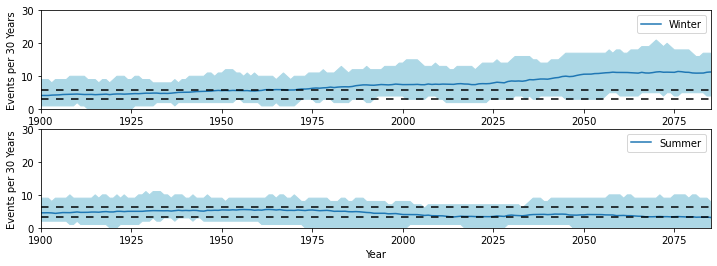

In [24]:
ax=emergePlot(
    compoundCountsXr.sel(fire='pos',experiment='ssp585',drop=True),
    compoundCountsXr.sel(fire='pos',experiment='piControl',drop=True),
    xlim=[1900,2085]
)
plt.xlabel('Year')

ax[0].legend(['Winter'])
ax[1].legend(['Summer'])

ax[0].set_ylim([0,30])
ax[1].set_ylim([0,30])



(0.0, 20.0)

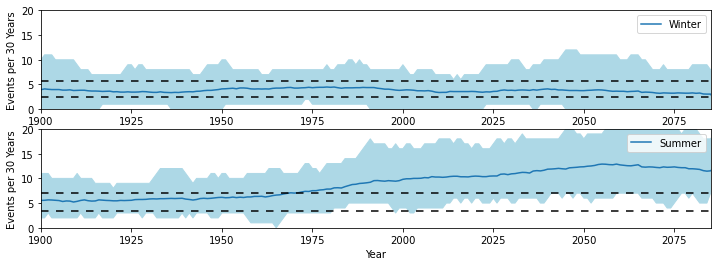

In [25]:
ax=emergePlot(
    compoundCountsXr.sel(fire='neg',experiment='ssp585',drop=True),
    compoundCountsXr.sel(fire='neg',experiment='piControl',drop=True)
)
plt.xlabel('Year')


ax[0].legend(['Winter'])
ax[1].legend(['Summer'])
ax[0].set_xlim([1900,2085])
ax[1].set_xlim([1900,2085])

ax[0].set_ylim([0,20])
ax[1].set_ylim([0,20])



# Time of emergence - Fire Pos / Dry

Do a plot to show time of emergence.
Using mean/min/max in each interval as the trend, and number of events (95%CI) in piControl as the baseline

In [26]:
indexSet = 'ecCombinedDmiSam'
compounds = [
    'all3','enso+iod','enso+sam','iod+sam'
]
rollingFirePos=firePos.rolling(year=30,min_periods=15,center=True).sum('year')
rollingFireNeg=fireNeg.rolling(year=30,min_periods=15,center=True).sum('year')

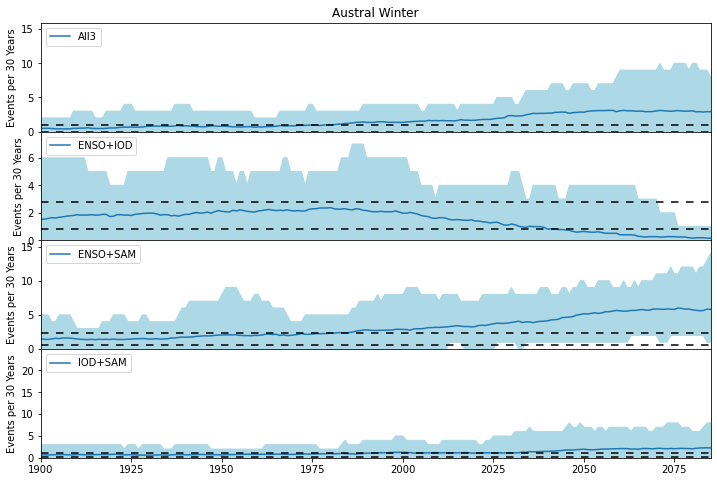

In [27]:
ax=emergePlot(
    rollingFirePos.ecCombinedDmiSamwinter.sel(compound=compounds).to_dataset('compound'), 
    piConPos.ecCombinedDmiSamwinter.sel(compound=compounds).to_dataset('compound').rolling(year=30,min_periods=15,center=True).sum('year'),
    xlim=[1900,2085]
)

ax[0].set_title('Austral Winter')
ax[0].legend(['All3'], loc='upper left')
ax[1].legend(['ENSO+IOD'], loc='upper left')
ax[2].legend(['ENSO+SAM'], loc='upper left')
ax[3].legend(['IOD+SAM'], loc='upper left')

ax[0].set_ylim([0,15.9])
ax[1].set_ylim([0,7.9])
ax[2].set_ylim([0,15.9])
ax[3].set_ylim([0,24.9])

[axx.set_xticklabels([]) for axx in ax[:-1]]

plt.subplots_adjust(hspace=0)




As there is a trend towards SAM dominating, plot how SAM events are compounding the precvioudly ENSO/IOD only to create a greater impact.

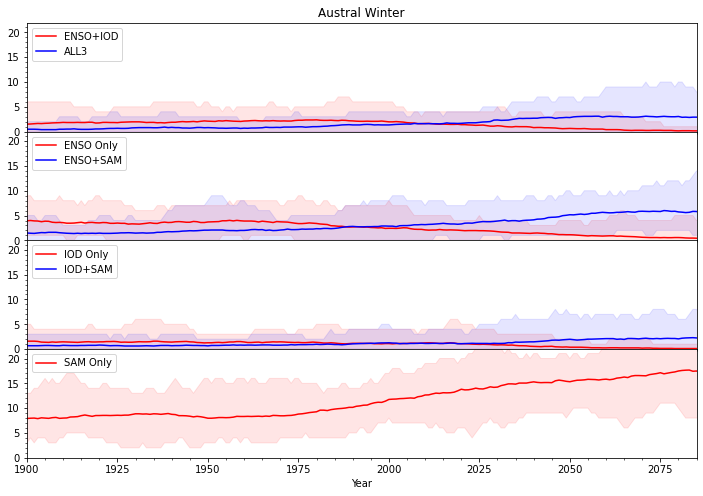

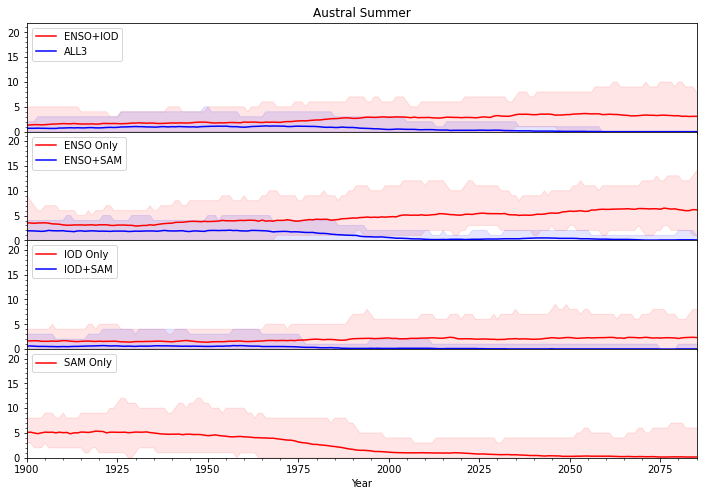

In [28]:
for iSeason in ['winter','summer']:
    plt.figure(figsize=(12,8))
    axx=list()
    iPlot=1
    for indexPair in [
        ['enso+iod','all3'],
        ['enso','enso+sam'],
        ['iod','iod+sam'],
        ['sam']
    ]:
        axx.append(plt.subplot(4,1,iPlot))
        overlaidEmergePlot(
            rollingFirePos[indexSet+iSeason].sel(
                compound=indexPair
            ).to_dataset('compound')
        )
        plt.ylabel('')
        plt.xlim([1900,2085])
        plt.ylim([0,21.9])
        iPlot=iPlot+1

    plt.subplots_adjust(hspace=0)
    axx[0].set_title('Austral '+iSeason.capitalize())

    [ax.set_xticklabels([]) for ax in axx[:-1]]

    axx[0].legend(['ENSO+IOD','ALL3'], loc='upper left')
    axx[1].legend(['ENSO Only','ENSO+SAM'], loc='upper left')
    axx[2].legend(['IOD Only','IOD+SAM'], loc='upper left')
    axx[3].legend(['SAM Only'], loc='upper left')



# Time of Emergence - Fire Neg / Wet

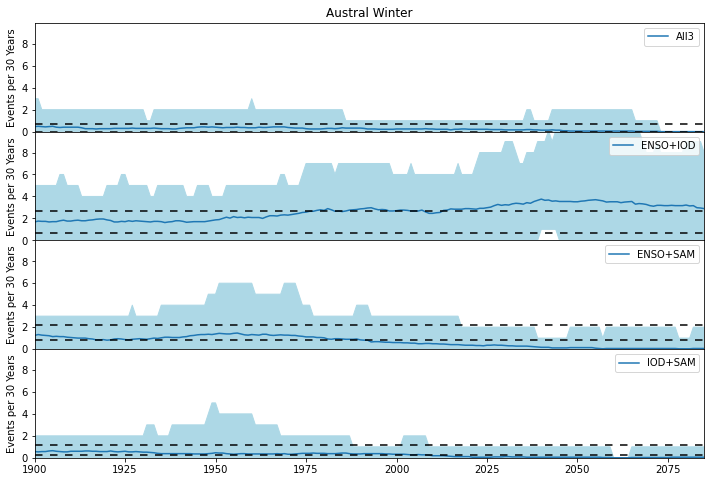

In [29]:
ax=emergePlot(
    fireNeg.ecCombinedDmiSamwinter.sel(compound=compounds).to_dataset('compound').rolling(year=30,min_periods=15,center=True).sum('year'), 
    piConNeg.ecCombinedDmiSamwinter.sel(compound=compounds).to_dataset('compound').rolling(year=30,min_periods=15,center=True).sum('year'),
    xlim=[1900,2085]
)

ax[0].set_title('Austral Winter')
ax[0].legend(['All3'])
ax[1].legend(['ENSO+IOD'])
ax[2].legend(['ENSO+SAM'])
ax[3].legend(['IOD+SAM'])

[axx.set_ylim([0,9.9]) for axx in ax]
[axx.set_xticklabels([]) for axx in ax[:-1]]

plt.subplots_adjust(hspace=0)




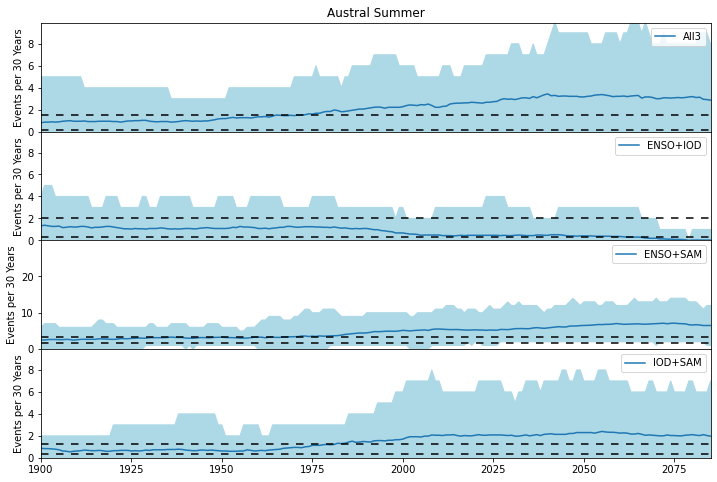

In [30]:
ax=emergePlot(
    fireNeg.ecCombinedDmiSamsummer.sel(compound=compounds).to_dataset('compound').rolling(year=30,min_periods=15,center=True).sum('year'), 
    piConNeg.ecCombinedDmiSamsummer.sel(compound=compounds).to_dataset('compound').rolling(year=30,min_periods=15,center=True).sum('year'),
    xlim=[1900,2085]
)

ax[0].set_title('Austral Summer')
ax[0].legend(['All3'])
ax[1].legend(['ENSO+IOD'])
ax[2].legend(['ENSO+SAM'])
ax[3].legend(['IOD+SAM'])

[axx.set_ylim([0,9.9]) for axx in ax]
ax[2].set_ylim([0,29.9])
[axx.set_xticklabels([]) for axx in ax[:-1]]

plt.subplots_adjust(hspace=0)




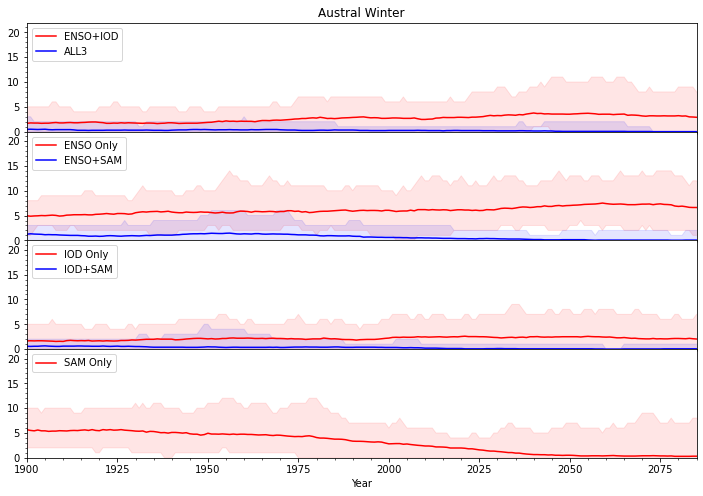

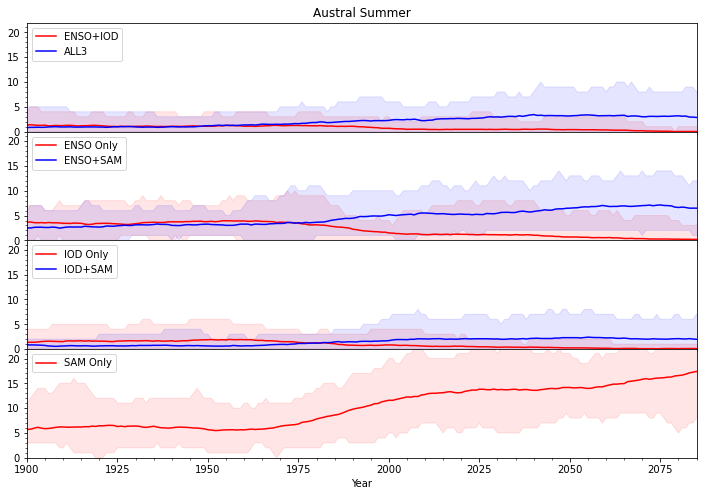

In [31]:
for iSeason in ['winter','summer']:
    plt.figure(figsize=(12,8))
    axx=list()
    iPlot=1
    for indexPair in [
        ['enso+iod','all3'],
        ['enso','enso+sam'],
        ['iod','iod+sam'],
        ['sam']
    ]:
        axx.append(plt.subplot(4,1,iPlot))
        overlaidEmergePlot(
            rollingFireNeg[indexSet+iSeason].sel(
                compound=indexPair
            ).to_dataset('compound')
        )
        plt.ylabel('')
        plt.xlim([1900,2085])
        plt.ylim([0,21.9])
        iPlot=iPlot+1

    plt.subplots_adjust(hspace=0)
    axx[0].set_title('Austral '+iSeason.capitalize())

    [ax.set_xticklabels([]) for ax in axx[:-1]]

    axx[0].legend(['ENSO+IOD','ALL3'], loc='upper left')
    axx[1].legend(['ENSO Only','ENSO+SAM'], loc='upper left')
    axx[2].legend(['IOD Only','IOD+SAM'], loc='upper left')
    axx[3].legend(['SAM Only'], loc='upper left')



# Index comparisons - ENSO E vs C

all enso


(0.0, 20.0)

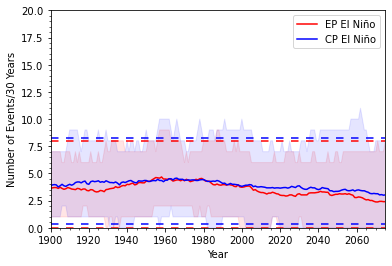

In [32]:
print('all enso')
overlaidEmergePlot(
        firePos[[
            'eIndexDmiSamwinter','cIndexDmiSamwinter'
               ]].sel(compound=['enso','enso+iod','all3']).any('compound').rolling(year=30,min_periods=15,center=True).sum('year'), 
        piConPos[[
            'eIndexDmiSamwinter','cIndexDmiSamwinter'
                ]].sel(compound=['enso','enso+iod','all3']).any('compound').where(piConPos.eIndexDmiSamsummer.isnull()==False).rolling(year=30,min_periods=15,center=True).sum('year') 
)
plt.legend(['EP El Niño', '_no_','_no_', 'CP El Niño'])
#plt.legend(['El Niño+East IO','El Niño+DMI'])
plt.xlim([1900,2075])
plt.ylim([0,20])


not compound enso


(0.0, 20.0)

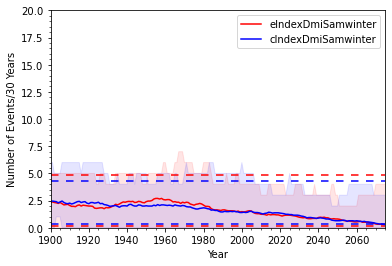

In [33]:
print('not compound enso')
overlaidEmergePlot(
        firePos[[
            'eIndexDmiSamwinter','cIndexDmiSamwinter'
               ]].sel(compound=['enso']).any('compound').rolling(year=30,min_periods=15,center=True).sum('year'), 
        piConPos[[
            'eIndexDmiSamwinter','cIndexDmiSamwinter'
                ]].sel(compound=['enso']).any('compound').where(piConPos.eIndexDmiSamsummer.isnull()==False).rolling(year=30,min_periods=15,center=True).sum('year') 
)
plt.legend()
#plt.legend(['El Niño+East IO','El Niño+DMI'])
plt.xlim([1900,2075])
plt.ylim([0,20])


# Impacts

Calculate covariance between indeces and rainfall

In [34]:
tradIndecesXr.sel(experiment='ssp585',year=slice(1850,2098),drop=True)

<xarray.Dataset>
Dimensions:                 (year: 249, model: 37)
Coordinates:
  * year                    (year) int64 1850 1851 1852 1853 ... 2096 2097 2098
  * model                   (model) object 'ACCESS-CM2' ... 'UKESM1-0-LL'
Data variables: (12/19)
    backgroundSstNoDetrend  (model, year) float64 -0.224 0.05919 ... 5.613 5.232
    nino3                   (model, year) float64 -0.4135 0.7115 ... 1.932 0.528
    samWinter               (model, year) float64 -0.5221 -0.6108 ... 3.346
    samSummer               (model, year) float64 -0.8385 -4.552 ... 3.706 4.008
    nino4NoDetrend          (model, year) float64 -0.1826 0.4717 ... 6.61 5.098
    westIONoDetrend         (model, year) float64 -0.1756 0.1422 ... 5.259 5.202
    ...                      ...
    dmiNoDetrend            (model, year) float64 0.5983 -0.009583 ... 1.782
    dmiRollingDetrend       (model, year) float64 0.1778 -0.3087 ... 0.7566
    eastIORollingDetrend    (model, year) float64 -0.4793 0.3339 ... -0.7707
    nino34RollingDetrend    (model, year) float64 -0.6412 0.5291 ... -0.814
    westIORollingDetrend    (model, year) float64 -0.3015 0.02516 ... -0.01403
    nino4RollingDetrend     (model, year) float64 -0.4306 0.2568 ... -0.5486

In [35]:
ecXr.sel(experiment='ssp585',year=slice(1850,2098),drop=True)

<xarray.Dataset>
Dimensions:  (year: 249, model: 37)
Coordinates:
  * year     (year) int64 1850 1851 1852 1853 1854 ... 2094 2095 2096 2097 2098
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
Data variables:
    eIndex   (model, year) float64 -0.5456 0.3002 0.3981 ... 1.118 2.412 1.544
    cIndex   (model, year) float64 -0.0532 0.9603 1.201 ... 0.1701 1.407 -1.124

In [36]:
domain(prXr).mean(['lat','lon'])

<xarray.Dataset>
Dimensions:      (model: 37, year: 249)
Coordinates:
  * model        (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * year         (year) int64 1850 1851 1852 1853 1854 ... 2095 2096 2097 2098
Data variables:
    Winter Rain  (model, year) float64 -8.858 4.332 -1.325 ... -0.8271 -4.106
    Summer Rain  (model, year) float64 -7.191 -23.39 -16.91 ... -2.546 3.867

In [37]:
for iSeason in ['Winter','Summer']:
    print(iSeason)
    for index in [
    'dmi','dmiRollingDetrend',
    'nino34','nino34NoDetrend','nino34RollingDetrend'
]:
        print(index)
        
        rainXr=domain(prXr[iSeason+' Rain']).mean(['lat','lon'])
        
        print(xarray.cov(
            tradIndecesXr[index].sel(experiment='ssp585',year=slice(2050,2098),drop=True),
            rainXr-rainXr.rolling(year=30,center=True).mean('year'),
            dim='year'
        ).mean('model').values)


Winter
dmi
-3.6979476515182066
dmiRollingDetrend
-3.5089747690540367
nino34
-4.486957329237159
nino34NoDetrend
-5.554375375183148
nino34RollingDetrend
-5.31342096933556
Summer
dmi
-2.612161604073336
dmiRollingDetrend
-2.49381773797234
nino34
-6.706566601617252
nino34NoDetrend
-8.377968314341054
nino34RollingDetrend
-8.109416528547765


In [38]:
for iSeason in ['Winter','Summer']:
    print(iSeason)
    rainXr=domain(prXr[iSeason+' Rain']).mean(['lat','lon'])

    
    for index in [
        'eIndex','cIndex',
    ]:
        print(index)
        print(xarray.cov(
            ecXr[index].sel(experiment='ssp585',year=slice(2050,2098),drop=True),
            rainXr-rainXr.rolling(year=30,center=True).mean('year'),
            dim='year'
        ).mean('model').values)

        var = ecXr[index].sel(experiment='ssp585',year=slice(2050,2098),drop=True)

        print(
            xarray.cov(
                var-var.rolling(year=30,center=True).mean('year'),
                rainXr-rainXr.rolling(year=30,center=True).mean('year'),
                dim='year'
            ).mean('model').values
        )


Winter
eIndex
-2.3260498289311298
-2.6403080534121495
cIndex
-5.612686797822059
-5.3558038091964795
Summer
eIndex
-4.188521732320155
-4.4316121897000125
cIndex
-7.774314459032875
-7.756086601700883


Fire:pos
winter


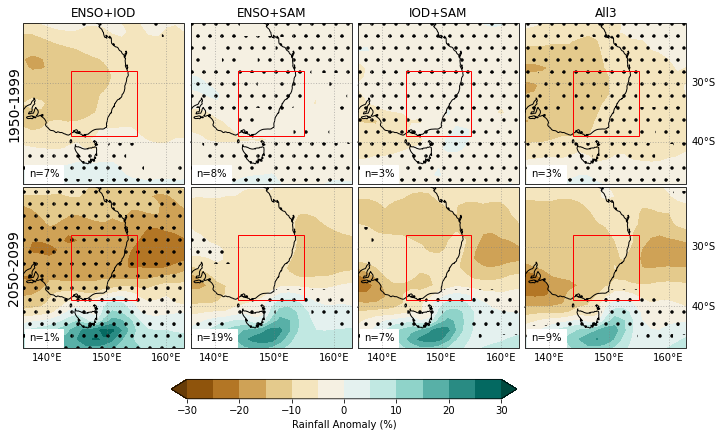

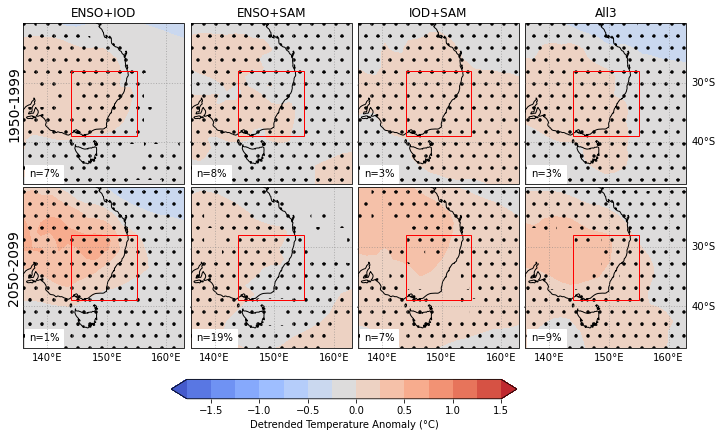

summer


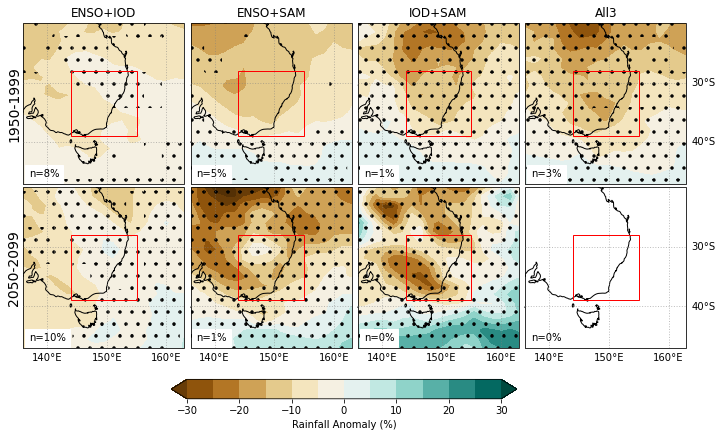

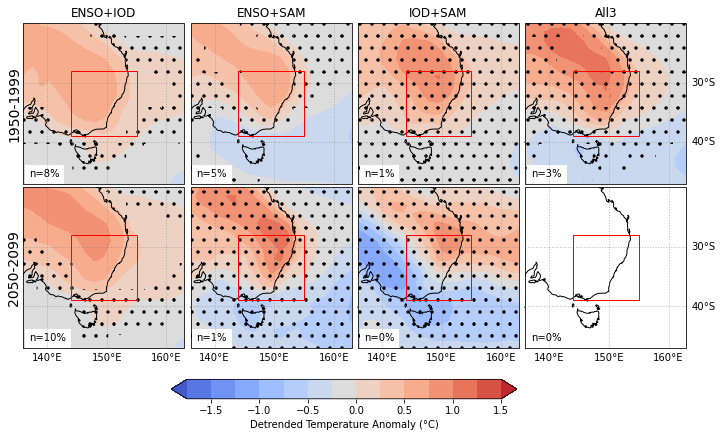

Fire:neg
winter


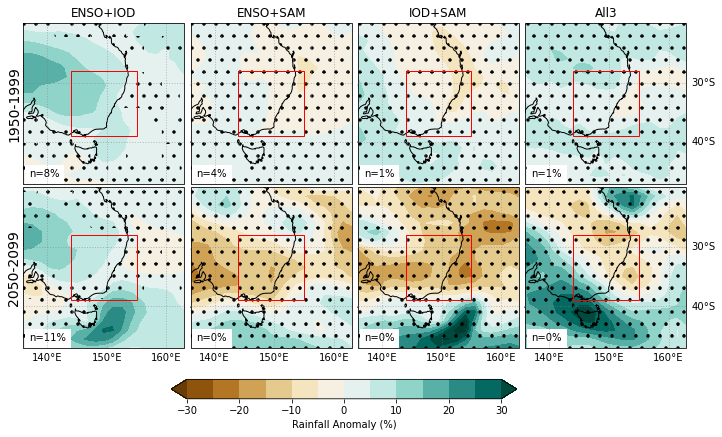

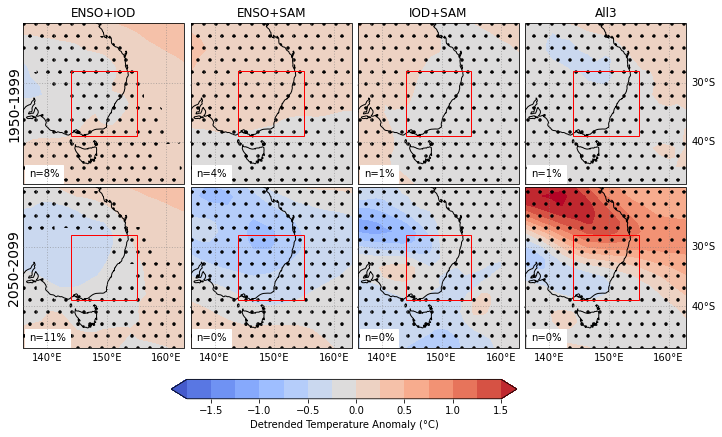

summer


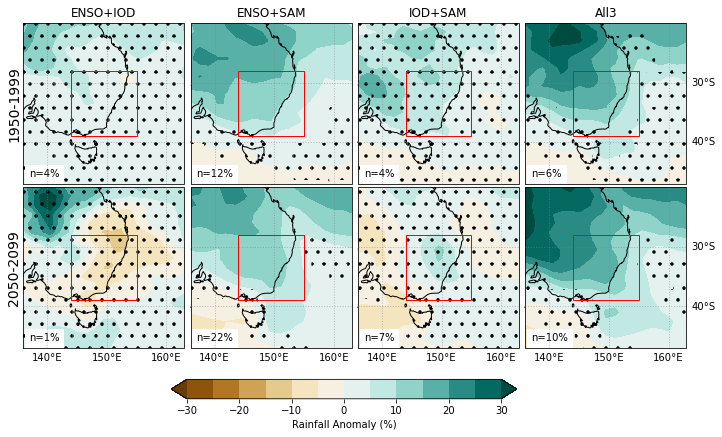

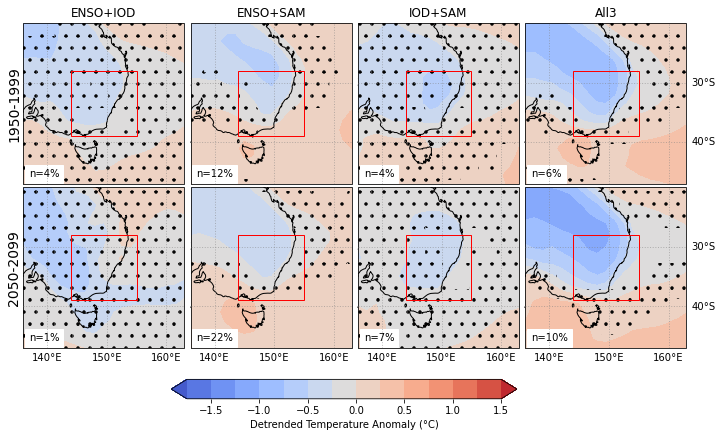

In [39]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=multiPlotter(
            prXr[iSeason.capitalize()+' Rain'], #sourceData
            allCompoundsXr[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, experiment='ssp585', drop=True), #masks for event types
            eventsList, #names of event types
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('All3')
        plt.show()
        
        axs=multiPlotter(
            detrendTsXr[iSeason.capitalize()+' Temp'],
            allCompoundsXr[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, experiment='ssp585', drop=True), 
            eventsList,
            cbarLabel='Detrended Temperature Anomaly (°C)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('All3')
        plt.show()

# ENSO comparisons

pos
winter


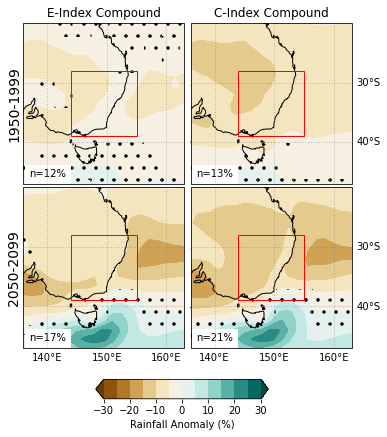

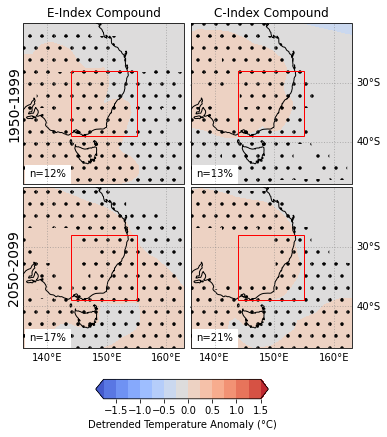

summer


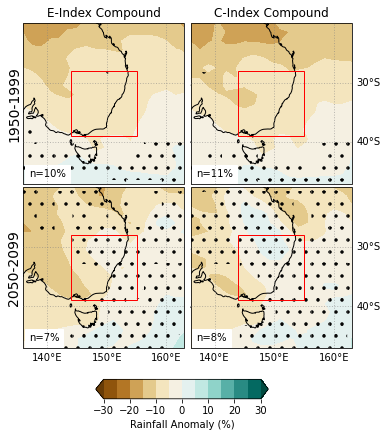

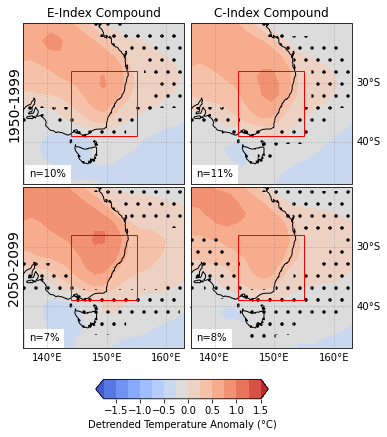

neg
winter


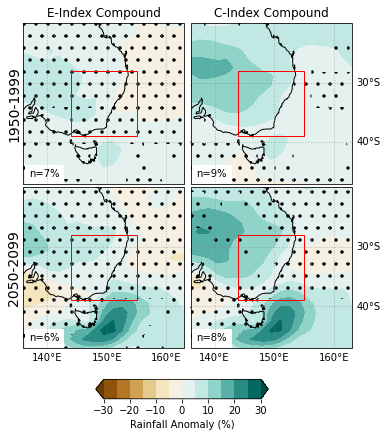

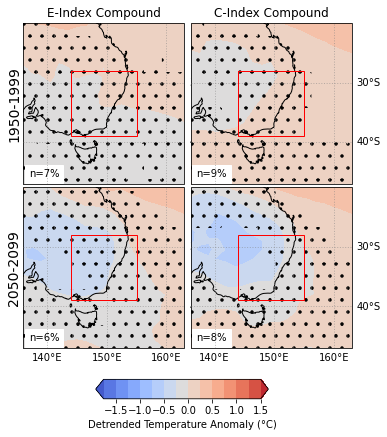

summer


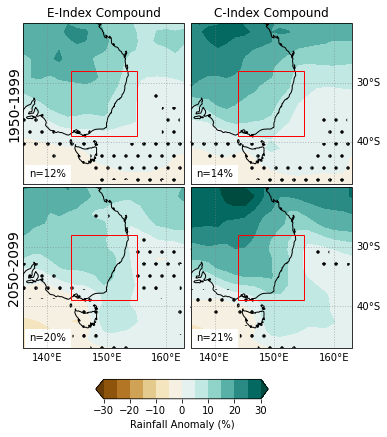

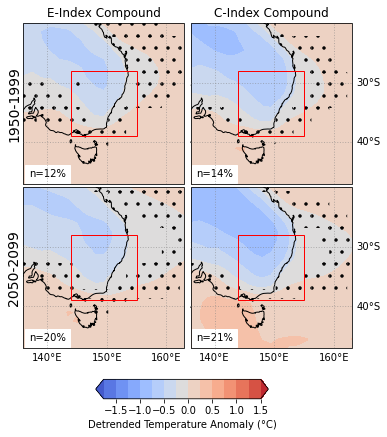

In [40]:
%run helpers/impactPlots.ipynb
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
            print(iSeason)

            axs=multiPlotter(
                prXr[iSeason.capitalize()+' Rain'], #sourceData
                allCompoundsXr[
                    ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason]
                ].sel(fire=iFire,compound=['enso+iod','enso+sam','all3'],experiment='ssp585',drop=True).any('compound'), #masks for event types
                ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason],
                cbarLabel='Rainfall Anomaly (%)'
            )
            axs[0].set_title('E-Index Compound')
            axs[1].set_title('C-Index Compound')


            plt.show()

            axs=multiPlotter(
                detrendTsXr[iSeason.capitalize()+' Temp'], #sourceData
                allCompoundsXr[
                    ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason]
                ].sel(fire=iFire,compound=['enso+iod','enso+sam','all3'],experiment='ssp585',drop=True).any('compound'), #masks for event types
                ['eIndexDmiSam'+iSeason,'cIndexDmiSam'+iSeason],
                cbarLabel='Detrended Temperature Anomaly (°C)'
            )
            axs[0].set_title('E-Index Compound')
            axs[1].set_title('C-Index Compound')

            plt.show()


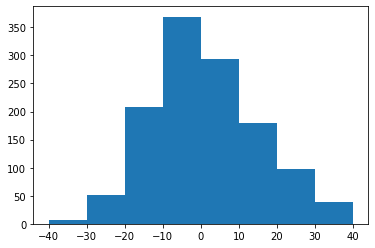

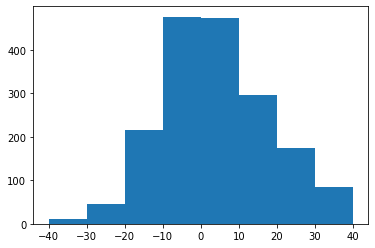

In [41]:

import numpy as np
for iFire in ['pos','neg']:
    eventAnoms=domain(prXr[iSeason.capitalize()+' Rain'].where(
                            allCompoundsXr['ecCombinedDmiSam'+iSeason].sel(
                                compound=['enso+iod','enso+sam','iod+sam','all3'],
                                year=slice(2050,2099),
                                fire=iFire,
                                drop=True
                                ).any('compound')
                            )
                        ).mean(['lat','lon'])

    n=plt.hist(
        eventAnoms.values.flatten(),
        bins=[-40,-30,-20,-10,0,10,20,30,40]
    )
    
    plt.show()

winterPos


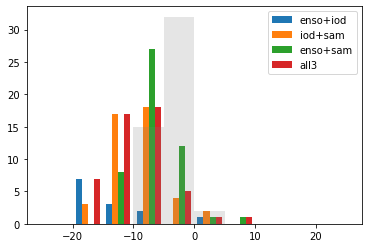

summerPos


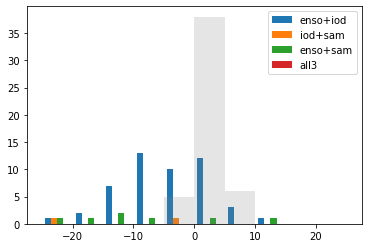

winterNeg


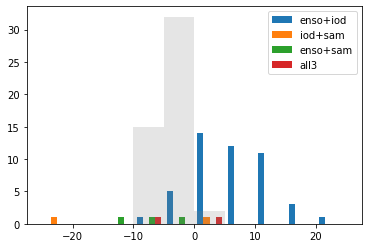

summerNeg


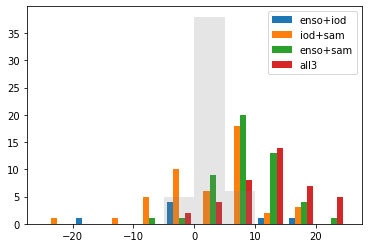

In [42]:
compounds=['enso+iod','iod+sam','enso+sam','all3']
import numpy as np
for iFire in ['pos','neg']:
    for iSeason in ['winter','summer']:
        print(iSeason+iFire.capitalize())
        
        #plot frequency of anoms, seperated by each compound
        eventAnoms=domain(prXr[iSeason.capitalize()+' Rain'].where(
                                allCompoundsXr['ecCombinedDmiSam'+iSeason].sel(
                                    compound=compounds,
                                    experiment='ssp585',
                                    year=slice(2050,2099),
                                    fire=iFire,
                                    drop=True
                                    )
                                )
                            ).to_dataset('compound').mean(['model','lat','lon'])

        n=plt.hist(
            [eventAnoms[iIndex].values.flatten() for iIndex in compounds],
            bins=np.arange(-25,26,5)
        )

        plt.legend(compounds)
        
        # in grey background, plot frequency of anoms for whole time period
        allYears=domain(
            prXr[iSeason.capitalize()+' Rain'].sel(year=slice(2050,2099))
        ).mean(['model','lat','lon'])
        
        n=plt.hist(
            allYears.values.flatten(),
            bins=np.arange(-25,26,5), 
            alpha=0.2,
            color='grey'
        )
        
        plt.show()

winterPos
<xarray.Dataset>
Dimensions:   ()
Data variables:
    enso+iod  float64 -13.73
    iod+sam   float64 -7.626
    enso+sam  float64 -6.531
    all3      float64 -9.873


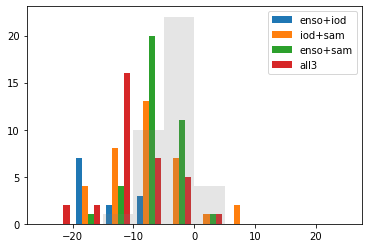

summerPos
<xarray.Dataset>
Dimensions:   ()
Data variables:
    enso+iod  float64 -3.334
    iod+sam   float64 -11.97
    enso+sam  float64 -10.7
    all3      float64 nan


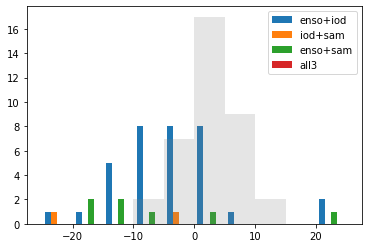

winterNeg
<xarray.Dataset>
Dimensions:   ()
Data variables:
    enso+iod  float64 5.009
    iod+sam   float64 -9.662
    enso+sam  float64 -7.488
    all3      float64 -0.657


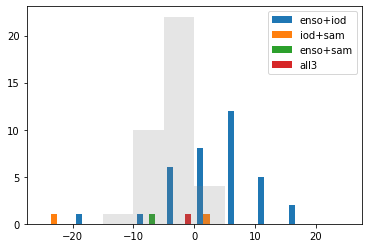

summerNeg
<xarray.Dataset>
Dimensions:   ()
Data variables:
    enso+iod  float64 -3.487
    iod+sam   float64 2.495
    enso+sam  float64 8.641
    all3      float64 13.35


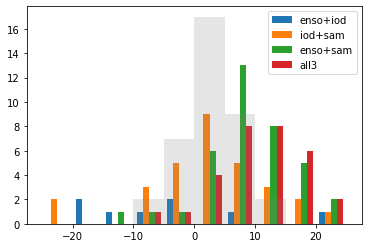

In [43]:
compounds=['enso+iod','iod+sam','enso+sam','all3']
import numpy as np
for iFire in ['pos','neg']:
    for iSeason in ['winter','summer']:
        print(iSeason+iFire.capitalize())
        
        #plot frequency of anoms, seperated by each compound
        eventAnoms=domain(prXr[iSeason.capitalize()+' Rain'].where(
                                allCompoundsXr['ecCombinedDmiSam'+iSeason].sel(
                                    compound=compounds,
                                    experiment='ssp585',
                                    year=slice(2050,2099),
                                    fire=iFire,
                                    drop=True
                                    )
                                )
                            ).to_dataset('compound').mean(['year','lat','lon'])
        print(eventAnoms.mean('model'))

        n=plt.hist(
            [eventAnoms[iIndex].values.flatten() for iIndex in compounds],
            bins=np.arange(-25,26,5)
        )

        plt.legend(compounds)
        
        # in grey background, plot frequency of anoms for whole time period
        allYears=domain(
            prXr[iSeason.capitalize()+' Rain'].sel(year=slice(2050,2099))
        ).mean(['year','lat','lon'])
        
        n=plt.hist(
            allYears.values.flatten(),
            bins=np.arange(-25,26,5), 
            alpha=0.2,
            color='grey'
        )
        
        plt.show()

In [44]:
allEventsXr

<xarray.Dataset>
Dimensions:     (experiment: 2, fire: 2, model: 37, year: 5341)
Coordinates:
  * experiment  (experiment) object 'piControl' 'ssp585'
  * year        (year) int64 1 2 3 4 5 6 7 ... 7888 7889 7890 7891 7892 7893
  * model       (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * fire        (fire) <U3 'pos' 'neg'
Data variables:
    cIndex      (fire, model, experiment, year) float64 nan nan nan ... nan nan
    eIndex      (fire, model, experiment, year) float64 nan nan nan ... nan nan
    ecCombined  (fire, model, experiment, year) float64 nan nan nan ... nan nan
    dmi         (fire, experiment, model, year) float64 nan nan nan ... nan nan
    samWinter   (fire, experiment, model, year) float64 nan nan nan ... nan nan
    samSummer   (fire, experiment, model, year) float64 nan nan nan ... nan nan

winterPos
<xarray.Dataset>
Dimensions:    ()
Data variables:
    eIndex     float64 -7.459
    cIndex     float64 -8.699
    dmi        float64 -9.391
    samWinter  float64 -3.652


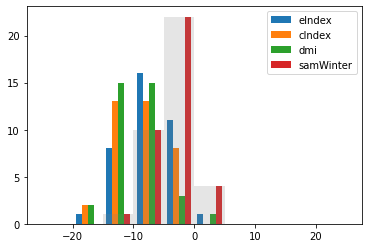

summerPos
<xarray.Dataset>
Dimensions:    ()
Data variables:
    eIndex     float64 -3.213
    cIndex     float64 -3.509
    dmi        float64 -1.314
    samSummer  float64 -15.15


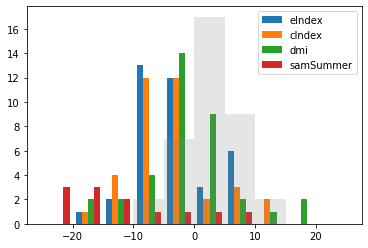

winterNeg
<xarray.Dataset>
Dimensions:    ()
Data variables:
    eIndex     float64 -1.011
    cIndex     float64 2.977
    dmi        float64 3.886
    samWinter  float64 -10.47


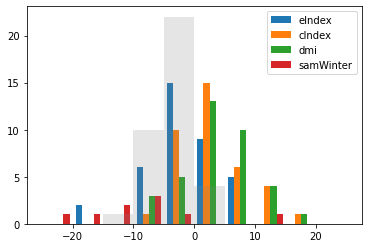

summerNeg
<xarray.Dataset>
Dimensions:    ()
Data variables:
    eIndex     float64 7.532
    cIndex     float64 11.88
    dmi        float64 8.609
    samSummer  float64 3.337


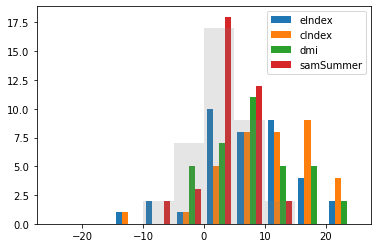

In [45]:
import numpy as np
for iFire in ['pos','neg']:
    for iSeason in ['winter','summer']:
        compounds=['eIndex','cIndex','dmi','sam'+iSeason.capitalize()]#,'samSummer','samWinter']

        print(iSeason+iFire.capitalize())
        
        #plot frequency of anoms, seperated by each compound
        eventAnoms=domain(prXr[iSeason.capitalize()+' Rain'].where(
                                allEventsXr[compounds].sel(
                                    experiment='ssp585',
                                    year=slice(2050,2099),
                                    fire=iFire,
                                    drop=True
                                    )
                                )
                            ).mean(['year','lat','lon'])
        print(eventAnoms.mean('model'))

        n=plt.hist(
            [eventAnoms[iIndex].values.flatten() for iIndex in compounds],
            bins=np.arange(-25,26,5)
        )

        plt.legend(compounds)
        
        # in grey background, plot frequency of anoms for whole time period
        allYears=domain(
            prXr[iSeason.capitalize()+' Rain'].sel(year=slice(2050,2099))
        ).mean(['year','lat','lon'])
        
        n=plt.hist(
            allYears.values.flatten(),
            bins=np.arange(-25,26,5), 
            alpha=0.2,
            color='grey'
        )
        
        plt.show()

In [59]:
eventsXr=xarray.open_dataset('results/cmip6Compounds.nc').sel(experiment='ssp585',year=slice(1850,2099),drop=True)

In [62]:
detrendEventsXr=allCompoundsXr.sel(experiment='ssp585',year=slice(1850,2099),drop=True)

In [63]:
diffEventsXr=eventsXr-detrendEventsXr

In [66]:
diffEventsXr.ecCombinedDmiSamsummer.sel(fire='neg')

<xarray.DataArray 'ecCombinedDmiSamsummer' (compound: 9, model: 37, year: 250)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ..., -1.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0., -1., -1.],
        [ 0.,  0.,  1., ...,  0., -1.,  0.],
        [ 0.,  0.,  0., ..., -1.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0., -1., -1.],
        [ 0.,  0.,  0., ...,  0., -1.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., -1.,  0.,  0.],
        [ 0.,  1.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ..., -1.,  0.,  0.]]])
Coordinates:
  * year      (year) int64 1850 1851 1852 1853 1854 ... 2095 2096 2097 2098 2099
  * model     (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'
  * compound  (compound) object 'nEvents' 'all3' ... 'sam' 'anyCompound'
    fire      <U3 'neg'

Fire:pos
winter


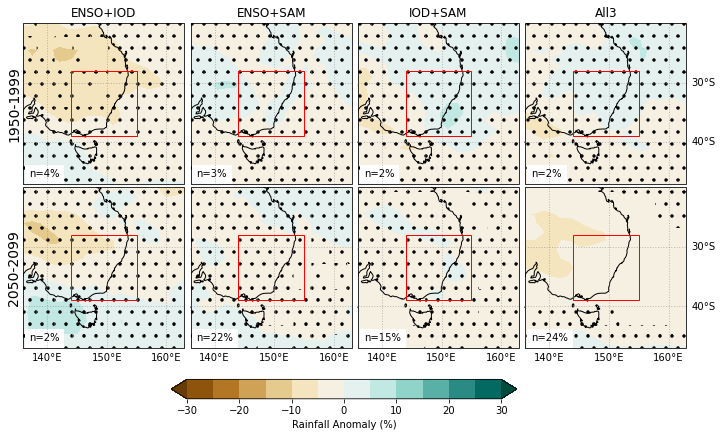

summer


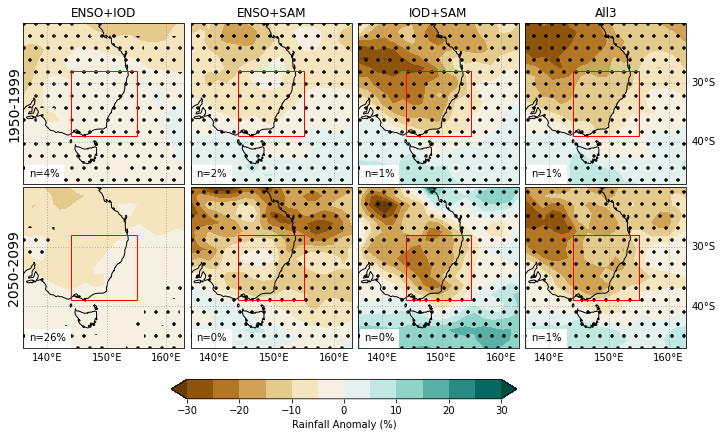

Fire:neg
winter


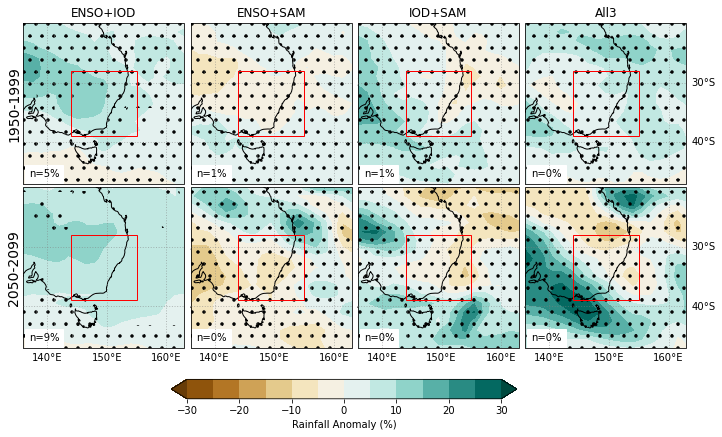

summer


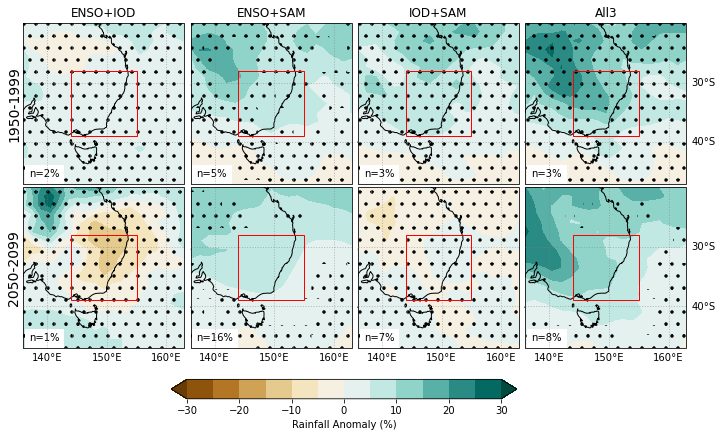

In [64]:


for iFire in ['pos','neg']:
    print('Fire:'+iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)
        axs=multiPlotter(
            detrend(prXr[iSeason.capitalize()+' Rain']), #sourceData
            diffEventsXr[indexSet+iSeason].to_dataset('compound').sel(fire=iFire, drop=True), #masks for event types
            eventsList, #names of event types
            cbarLabel='Rainfall Anomaly (%)'
        )
        axs[0].set_title('ENSO+IOD')
        axs[1].set_title('ENSO+SAM')
        axs[2].set_title('IOD+SAM')
        axs[3].set_title('All3')
        plt.show()
        
